In [1]:
import tensorflow as tf
import numpy as np
import os,math,re,sys
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #CPU Only

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPU Running

import matplotlib.pylab as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [2]:
strategy = tf.distribute.MirroredStrategy(devices=None) #Use all available GPUs or CPU
print("REPLICAS:", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
REPLICAS: 1


In [3]:
IMG_SIZE = [224, 224]
BATCH_SIZE = 12
EPOCHS = 40

LR_START = 0.0002
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 15
LR_EXP_DECAY = .8

def scheduler_epoch(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        learning_rate = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return learning_rate
                
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler_epoch, verbose=True)

In [4]:
DataSet_Path = '/104_Flowers'
Train_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_train.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_train.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_train.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_train.tfrecord'
}

Val_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_val.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_val.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_val.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_val.tfrecord'
}

TrainSet_Path = Train_Size_Choice[IMG_SIZE[0]]
ValSet_Path = Val_Size_Choice[IMG_SIZE[0]]

CLASS = ['toad lily', 'love in the mist', 'monkshood', 'azalea', 'fritillary', 
         'silverbush', 'canterbury bells', 'stemless gentian', 'pink primrose', 'buttercup', 
         'poinsettia', 'desert-rose', 'bird of paradise', 'columbine', 'frangipani', 
         'sweet pea', 'siam tulip', 'great masterwort', 'hard-leaved pocket orchid', 'marigold', 
         'foxglove', 'wild pansy', 'windflower', 'daisy', 'tiger lily', 
         'purple coneflower', 'orange dahlia', 'globe-flower', 'lilac hibiscus', 'fire lily', 
         'balloon flower', 'iris', 'bishop of llandaff', 'yellow iris', 'garden phlox', 
         'alpine sea holly', 'geranium', 'pink quill', 'tree poppy', 'spear thistle', 
         'bromelia', 'common dandelion', 'sword lily', 'peruvian lily', 'carnation', 
         'cosmos', 'spring crocus', 'lotus', 'bolero deep blue', 'anthurium', 
         'rose', 'water lily', 'primula', 'blackberry lily', 'gaura', 
         'trumpet creeper', 'globe thistle', 'sweet william', 'snapdragon', 'mexican petunia', 
         'cyclamen ', 'petunia', 'gazania', 'king protea', 'blanket flower', 
         'common tulip', 'giant white arum lily', 'wild rose', 'morning glory', 'thorn apple', 
         'pincushion flower', 'tree mallow', 'canna lily', 'camellia', 'pink-yellow dahlia', 
         'bee balm', 'wild geranium', 'artichoke', 'black-eyed susan', 'ruby-lipped cattleya', 
         'clematis', 'prince of wales feathers', 'hibiscus', 'cautleya spicata', 'lenten rose', 
         'red ginger', "colt's foot", 'hippeastrum ', 'mallow', 'californian poppy', 
         'corn poppy', 'moon orchid', 'passion flower', 'grape hyacinth', 'japanese anemone', 
         'watercress', 'cape flower', 'osteospermum', 'barberton daisy', 'bougainvillea', 
         'magnolia', 'sunflower', 'daffodil', 'wallflower']

NUM_TRAINING_IMG = 12753
STEPS_PER_EPOCH = NUM_TRAINING_IMG // BATCH_SIZE
NUM_VALIDATION_IMG = 3712
VALIDATION_STEPS = -(-NUM_VALIDATION_IMG // BATCH_SIZE) #The "-(- // )" trick rounds up instead of down


In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) #JPEG --> Tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.reshape(image, [*IMG_SIZE, 3])
    image = tf.image.resize(image, IMG_SIZE) #image must be 3-D, so resize it
    return image

def read_tfrecord(example):
    image_feature_dict = {
        'image': tf.io.FixedLenFeature([],tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_id': tf.io.FixedLenFeature([],tf.string)
    }
    example = tf.io.parse_single_example(example, image_feature_dict) #return a dict
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int64) #104 classes in[0,103]
    image_id = example['image_id'] 
    return image,label   #return a tuple

def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()

    if not ordered:
        ignore_order.deterministic = False # experimental_deterministic has been baned

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TrainSet_Path) #ordered default is False
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #Prepare later elements
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset(ValSet_Path, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.cache() #cache files in memory  Might lead to session die
    dataset = dataset.prefetch(AUTO)
    return dataset


In [6]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training label examples:", label.numpy())
labelarray = label.numpy()
print(labelarray[0],type(labelarray[0]))
imagearray = image.numpy()
print(imagearray[0], type(imagearray[0]))

Training data shapes:
(12, 224, 224, 3) (12,)
(12, 224, 224, 3) (12,)
(12, 224, 224, 3) (12,)
Training label examples: [21 25 21 67 41 76 87 39 67 93 12 11]
21 <class 'numpy.int64'>
[[[0.18039216 0.29411766 0.1764706 ]
  [0.18039216 0.29411766 0.1764706 ]
  [0.18039216 0.29411766 0.1764706 ]
  ...
  [0.01960784 0.0509804  0.        ]
  [0.01960784 0.0509804  0.        ]
  [0.01960784 0.0509804  0.        ]]

 [[0.17254902 0.28627452 0.16862746]
  [0.17254902 0.28627452 0.16862746]
  [0.17254902 0.28627452 0.16862746]
  ...
  [0.01960784 0.0509804  0.        ]
  [0.01960784 0.0509804  0.        ]
  [0.01960784 0.0509804  0.        ]]

 [[0.16470589 0.2784314  0.16862746]
  [0.16470589 0.2784314  0.16862746]
  [0.16078432 0.27450982 0.16470589]
  ...
  [0.01176471 0.04313726 0.        ]
  [0.01176471 0.04313726 0.        ]
  [0.01176471 0.04313726 0.        ]]

 ...

 [[0.00392157 0.0627451  0.        ]
  [0.00392157 0.0627451  0.        ]
  [0.         0.06666667 0.        ]
  ...
  [0.

In [7]:
PATCH_SIZE = 16
num_patches = (IMG_SIZE[0] // PATCH_SIZE) ** 2

projection_dim = 64
num_heads = 4
transformer_units = [ projection_dim * 2, projection_dim ] #Size of transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] #Size of the dense layers of final classifier

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self,images):
        batch_size = tf.shape(images)[0] #[batch, height, width, channel]
        print(batch_size)
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID'
        )
        print(patches.shape) # [batch, height_patch, width_patch, (height*width*channel)]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # -1 mean how many patches every image
        return patches


In [9]:
class PatchEncoder(tf.keras.layers.Layer):
    '''PatchEncoder layer 
    make patch + learnable position embedding --> projected vector 
    the size of vector: projection_dim'''
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units = projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim = num_patches, output_dim = projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units: # hidden_units[0], hidden_units[1]...hidden_units[n]
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=[*IMG_SIZE, 3]) #[224, 224, 3] --> input
    patches = Patches(PATCH_SIZE)(inputs) #return the whole patches of a batch image
    encodeed_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers): #Don not care about the value, just care about the loop times
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encodeed_patches)

        #multi-head attention layer：to learn which parts of the input to focus on
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                              key_dim=projection_dim,
                                                              dropout=0.1)(x1, x1)
        #skip connection
        x2 = tf.keras.layers.Add()([attention_output, encodeed_patches])

        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        #skip connection
        encodeed_patches = tf.keras.layers.Add()([x3, x2])

    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encodeed_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = tf.keras.layers.Dense(len(CLASS))(features)
    
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


In [11]:
with strategy.scope():
    model = create_vit_classifier()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
model.summary()

Tensor("patches/strided_slice:0", shape=(), dtype=int32)
(None, 14, 14, 768)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                 

In [12]:
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/40
Tensor("model/patches/strided_slice:0", shape=(), dtype=int32, device=/job:localhost/replica:0/task:0/device:GPU:0)
(None, 14, 14, 768)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Tensor("while/model/patches/strided_slice:0", shape=(), dtype=int32, device=/job:localho

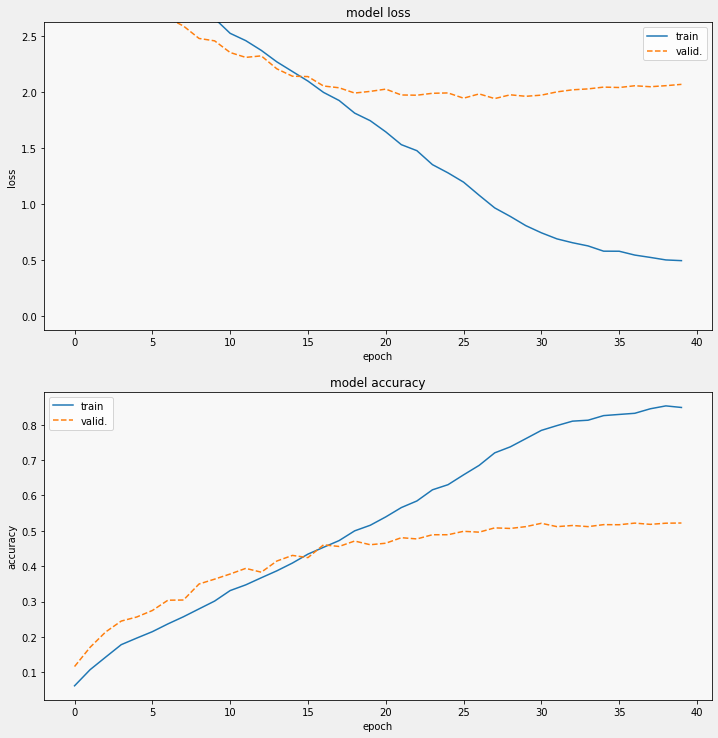

In [13]:
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation, '--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, ylim=[0,2.5])
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)


In [14]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMG))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)


Tensor("model/patches/strided_slice:0", shape=(), dtype=int32, device=/job:localhost/replica:0/task:0/device:GPU:0)
(None, 14, 14, 768)
Tensor("while/model/patches/strided_slice:0", shape=(), dtype=int32, device=/job:localhost/replica:0/task:0/device:GPU:0)
(None, 14, 14, 768)
Correct   labels:  (3712,) [79 85  8 ... 86 31 31]
Predicted labels:  (3712,) [79 49  8 ... 41 76 31]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


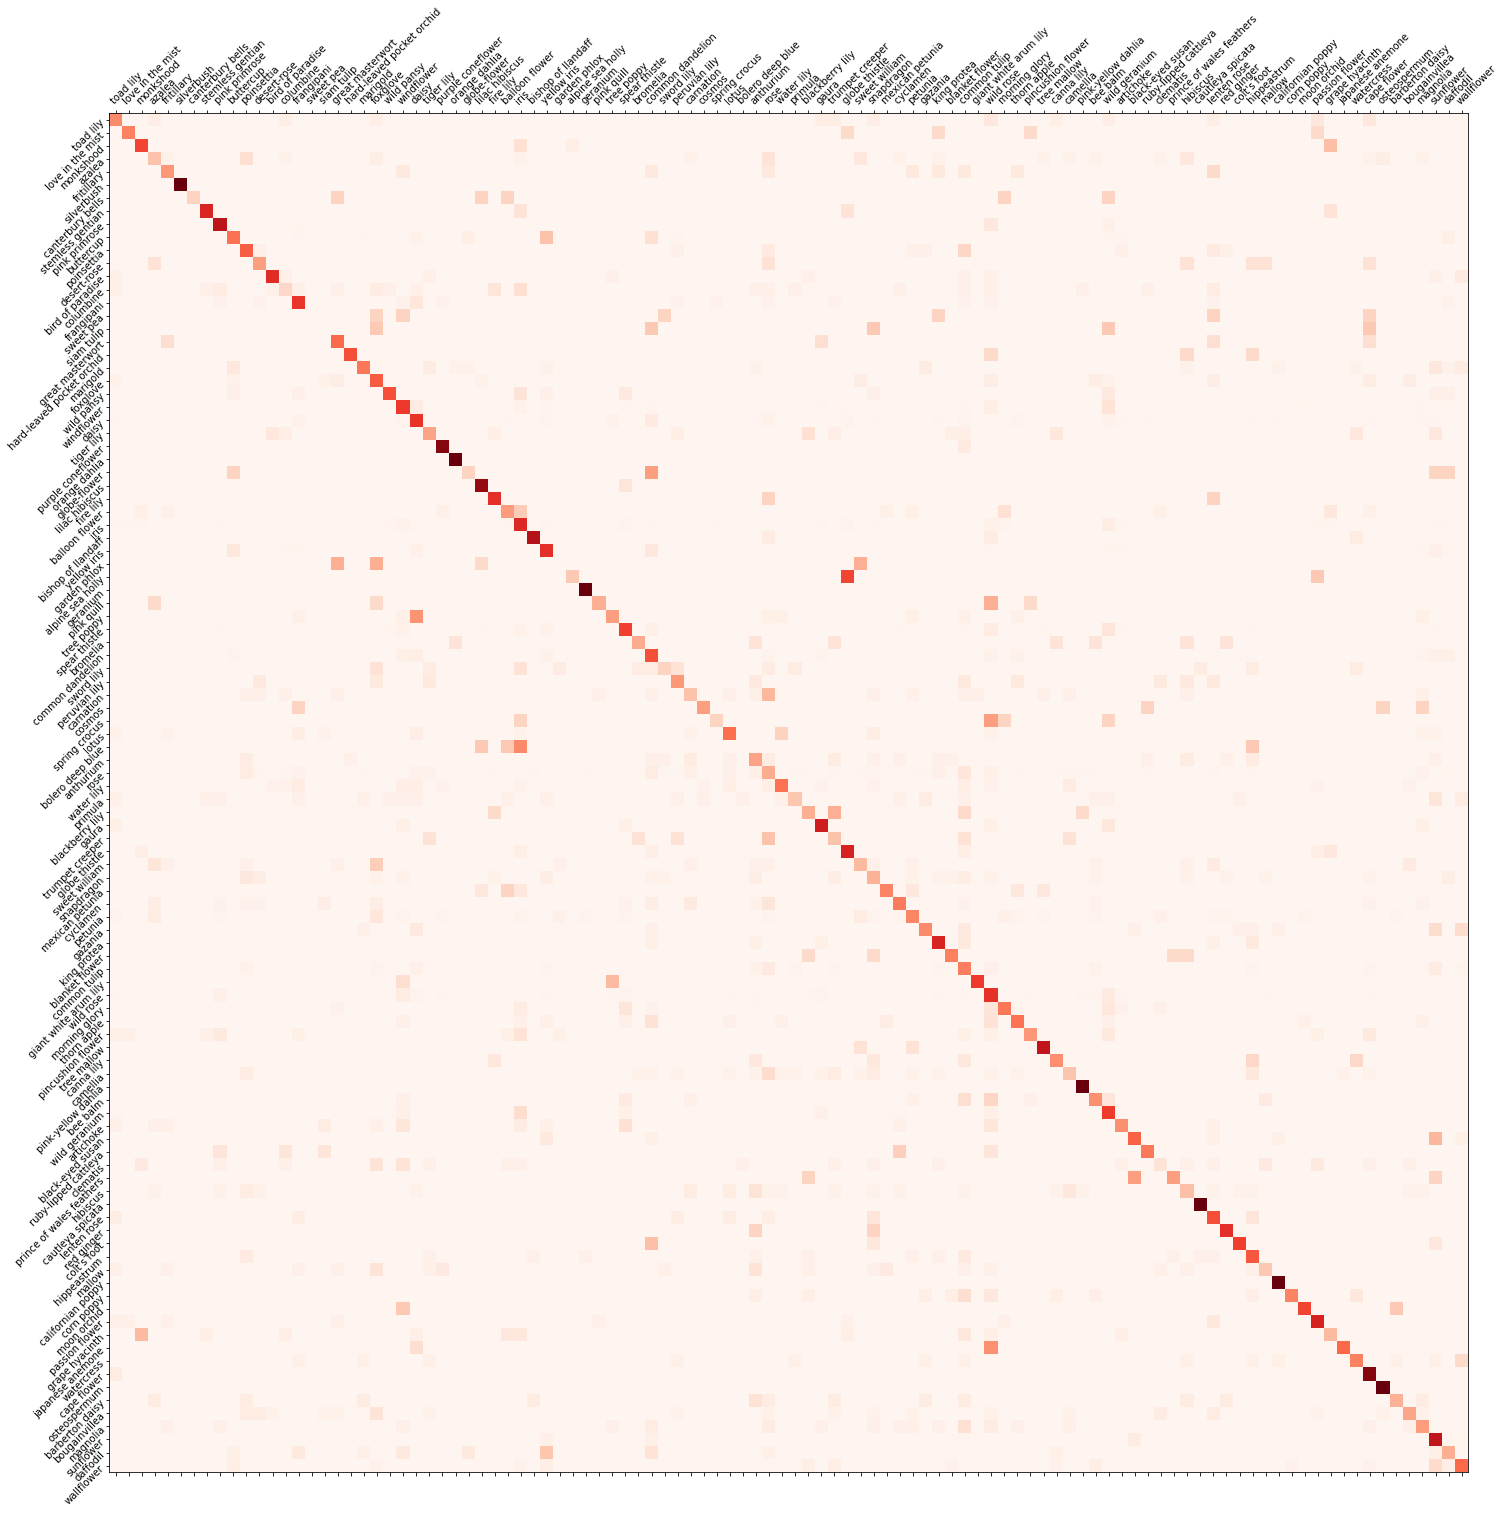

f1 score: 0.461, precision: 0.479, recall: 0.480


In [15]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(25,25))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASS)))
    ax.set_xticklabels(CLASS)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASS)))
    ax.set_yticklabels(CLASS)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #titlestring = ""
    #if score is not None:
    #    titlestring += 'f1 = {:.3f} '.format(score)
    #if precision is not None:
    #    titlestring += '\nprecision = {:.3f} '.format(precision)
    #if recall is not None:
    #    titlestring += '\nrecall = {:.3f} '.format(recall)
    #if len(titlestring) > 0:
    #    ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASS)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASS)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASS)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASS)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))